# AA1 lab 04

# Linear Regression: Life Expectancy Prediction

In [40]:
# Uncomment to upgrade packages
# !pip3 install pandas --user --upgrade --quiet
# !pip3 install numpy --user --upgrade --quiet
# !pip3 install scipy --user --upgrade --quiet
# !pip3 install statsmodels --user --upgrade --quiet
# !pip3 install seaborn --user --upgrade --quiet
# !pip3 install pillow --user --upgrade -- quiet
# !pip3 install matplotlib --user --upgrade --quiet

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

## SECTION 1: Our data

In this lab session we are going to predict the life expentancy of different countries during different years given different socio-economic markers.

As you can notice this dataset has a temporal component (life expectancy in a country one year can have a correlation with previous and posterior years). Normally this temporal component should be taken into account (breaks the iid assumption for example), however for simplicity we will ignore it. Treating the temporal component is outside the scope of the course.

In [42]:
# load data from file
life_expectancy_data = pd.read_csv('Life_Expectancy_Data.csv')
# remove spaces and symbols to avoid problems with statsmodel GLM
life_expectancy_data.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in life_expectancy_data.columns] 

# change the type of categorical variables into category
categorical_columns = list(life_expectancy_data.dtypes[life_expectancy_data.dtypes == 'O'].index.values)
for column in categorical_columns:
    life_expectancy_data[column] = life_expectancy_data[column].astype('category')

# peak into the data
life_expectancy_data.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.280,65.0,1154,...,6.0,8.16,65.0,0.1,584.259,3.374e+07,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.524,62.0,492,...,58.0,8.18,62.0,0.1,612.697,3.276e+05,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219,64.0,430,...,62.0,8.13,64.0,0.1,631.745,3.173e+07,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184,67.0,2787,...,67.0,8.52,67.0,0.1,669.959,3.697e+06,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097,68.0,3013,...,68.0,7.87,68.0,0.1,63.537,2.979e+06,18.2,18.2,0.454,9.5


It is always a good idea to do a small exploration of the data. Real data needs preprocessing and it is important to understand your dataset to be able to take good design decisions. 

Our dataset has 2938 samples and 21 predictive variables. Our target is `life_expectancy`. 

We are going to do a fast visualizacion of the data. In this visualization we use histograms for showing the distribution of the numerical variables and barplots for the categorical ones. 

With these kinds of easy visualizations we can see a lot of relevant information about our data, like if we have ourliers or if any variable has been wrongly encoded, or whether it "looks" Gaussian enough.

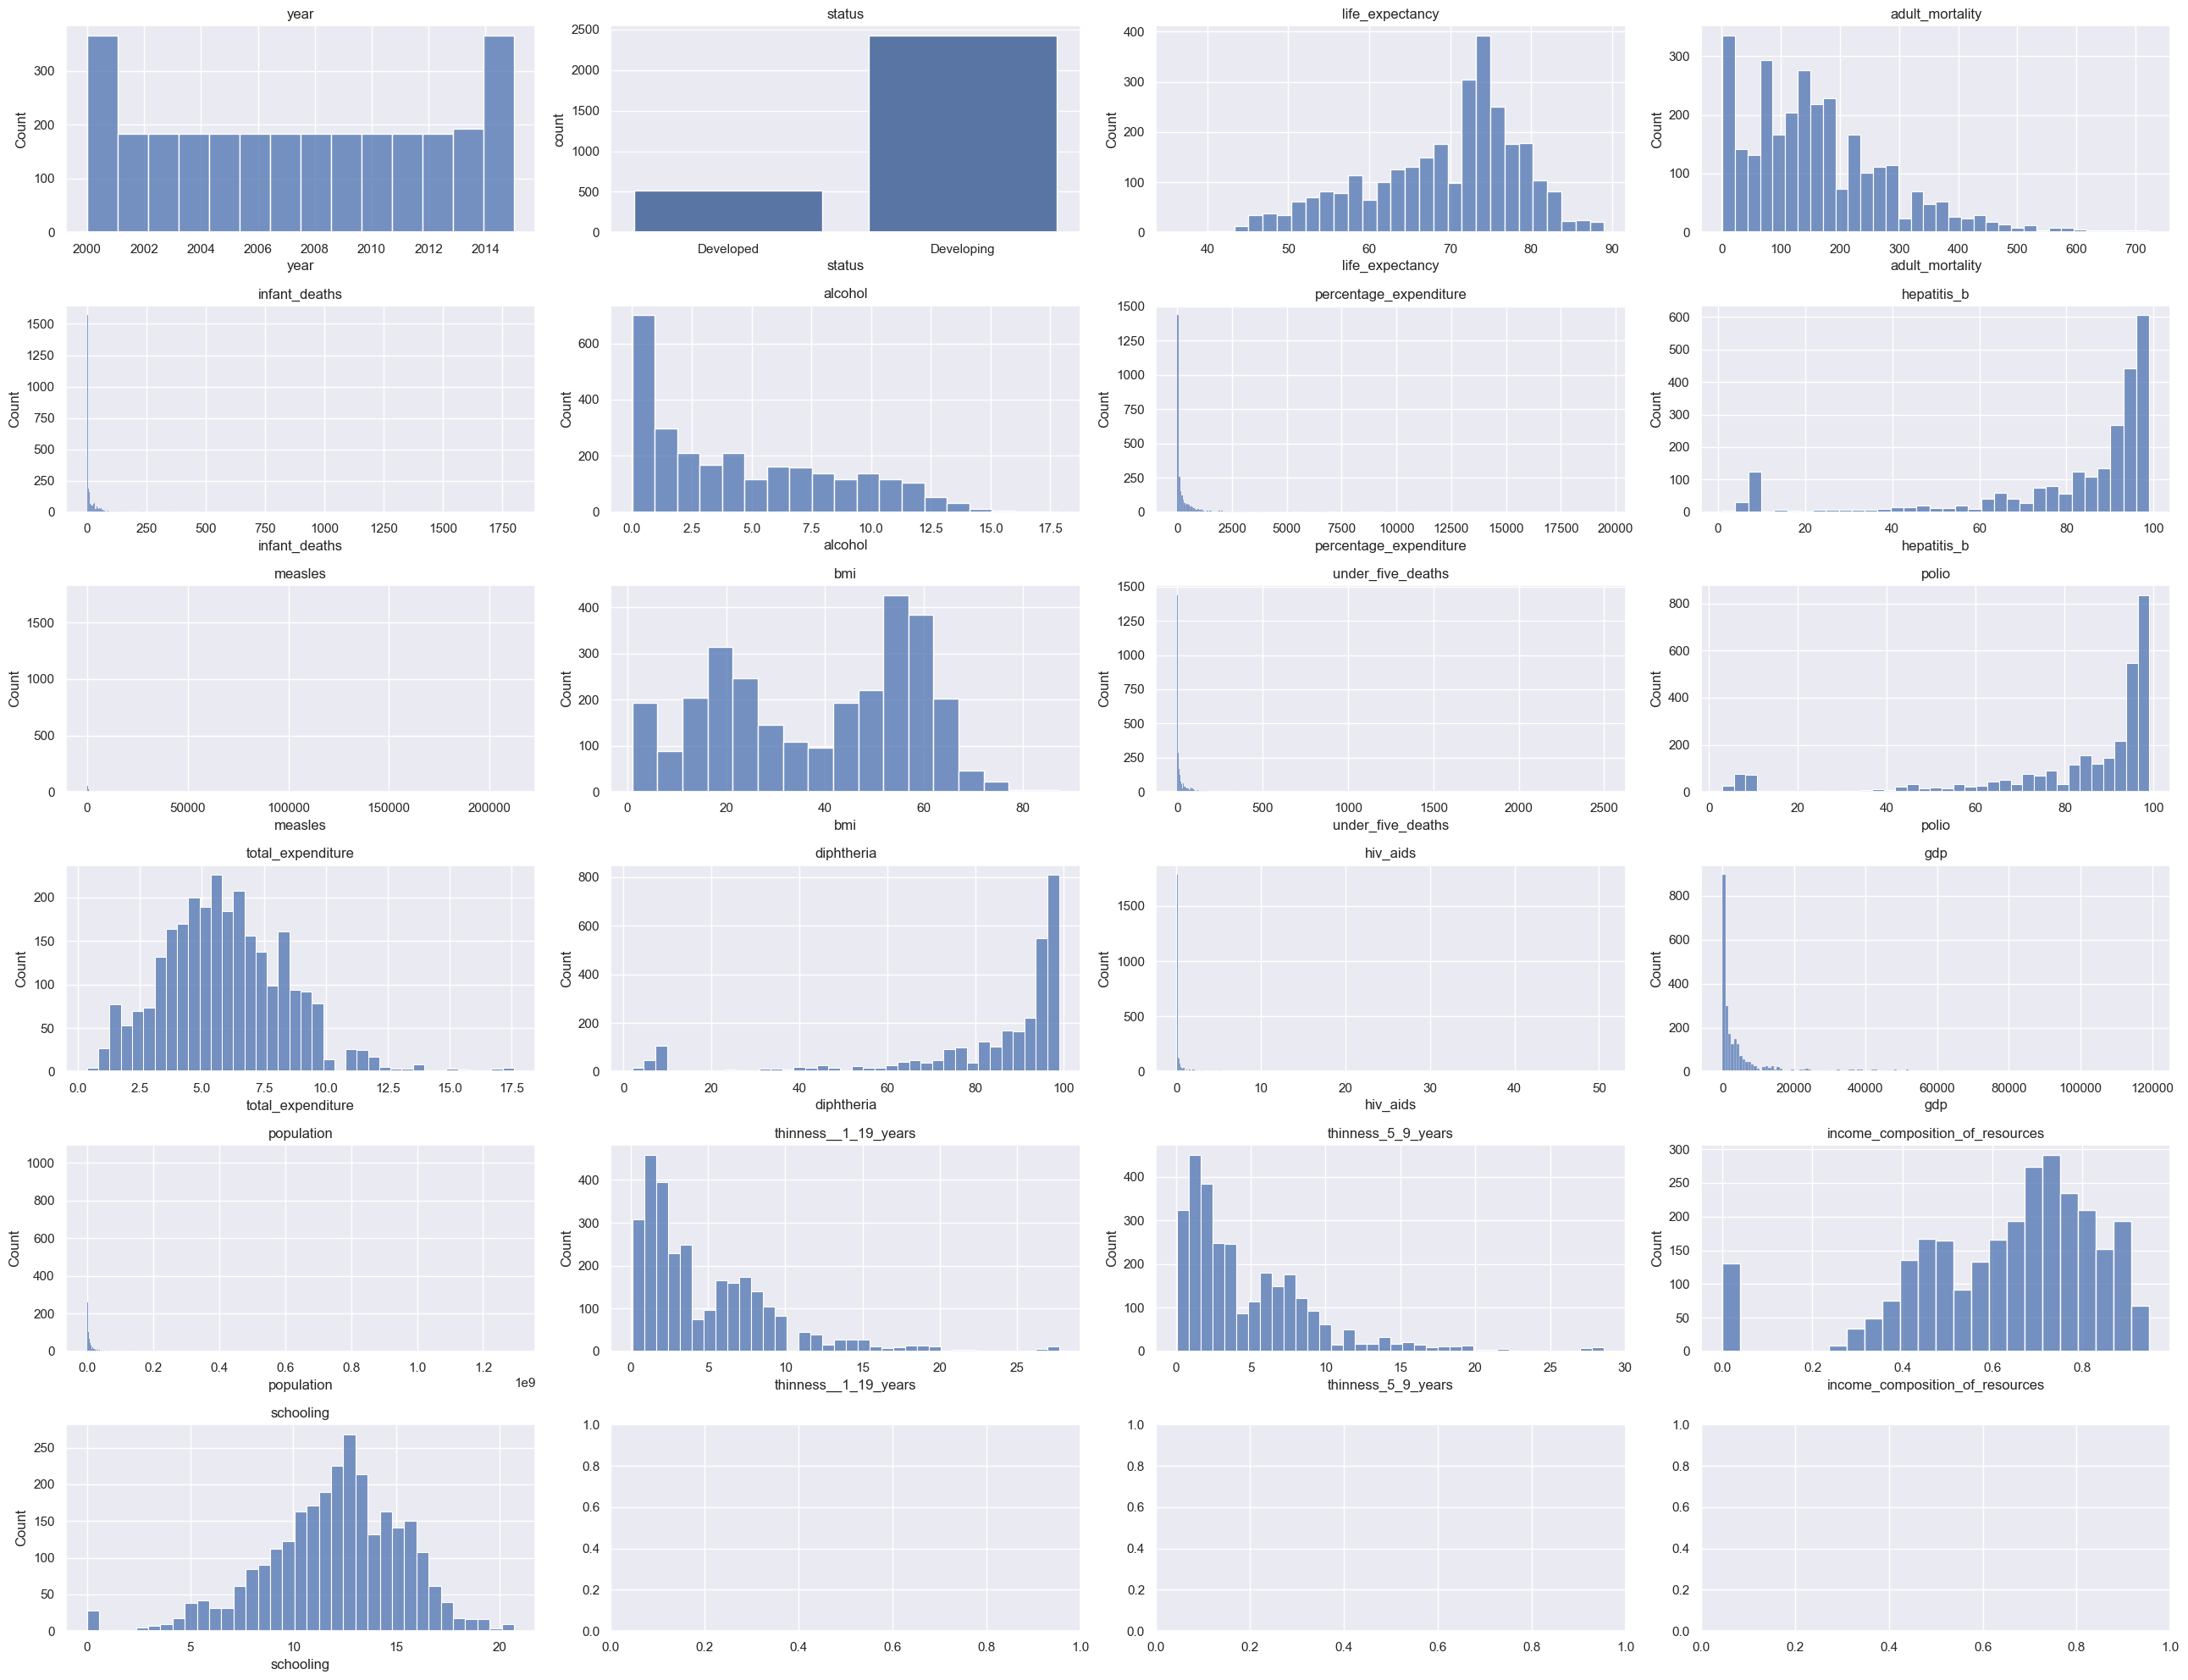

In [43]:
fig, axes = plt.subplots(6,4,figsize=(26,20))

# We will not plot country because it has too many categories.
for i, c in enumerate(life_expectancy_data.columns[1:]):
    ax = axes.reshape(-1)[i]
    if life_expectancy_data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=life_expectancy_data,ax=ax)
    else:
        b = sns.histplot(x=c,data=life_expectancy_data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

If you can't plot a effectively a categorical variable because it has too many categories, you can check it with a value_counts function.

In [44]:
life_expectancy_data['country'].value_counts()

country
Afghanistan              16
Peru                     16
Nicaragua                16
Niger                    16
Nigeria                  16
                         ..
Palau                     1
Niue                      1
Nauru                     1
Saint Kitts and Nevis     1
Dominica                  1
Name: count, Length: 193, dtype: int64

Now that we know what our data looks like, it is a good idea to check how many missing values do we have on each variable.  

In [45]:
life_expectancy_data.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 34
under_five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
hiv_aids                             0
gdp                                448
population                         652
thinness__1_19_years                34
thinness_5_9_years                  34
income_composition_of_resources    167
schooling                          163
dtype: int64

We can use all this information to design an effective pre-processing methodology and to choose an appropiate model adapted to our data. To show how important this is we will do two different pre-processings:
* **Generic Preprocessing**: Just transforms the data to something a model can process without throwing errors. Ignoring completely the dataset peculiarities. 
* **Specific Preprocessing**: Preprocessing adapted to the models we will be using and the data particularities.  

### Resampling protocol

We will use two data partitions (train and test) with cross-validation over the train partition for deciding hyperparameters.  We will explain in detail cross-validation on section 3. 

In [46]:
X = life_expectancy_data.loc[:,life_expectancy_data.columns != 'life_expectancy']
y = life_expectancy_data['life_expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## SECTION 2: Linear Regression (with minimum preprocessing of data)

This is the Linear Regression lab sesion. For this reason we will be using the Linear Regression, Lasso Regression and Rigdge Regression models. These models are not compatible with missing values nor categorical variables. So, the absolute minimum we need to do to our data is to remove samples with missings and categorical variables.

In [47]:
def minimum_preprocessing(X, y):
    print('Original shape:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    # We kill categorical columns
    X=X.drop(columns=categorical_columns)
    print('Droped: {}'.format(categorical_columns))
    # We remove missing values
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y

We will aply separately our preprocessing to our train and test partitions to avoid generating biases on our data. 

In [48]:
X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)

Original shape:(1968, 21)
Droped: ['country' 'status']
New shape:(1123, 19)
Original shape:(970, 21)
Droped: ['country' 'status']
New shape:(526, 19)


### Linear Regression

Small recap of how linear regression works: 

We model our regression function as 

 $y = f(x) + \epsilon = w^\top x  + \epsilon$
 
 where: 
 * $y$ is our target.
 * $w$ are the weights we will calculate.
 * $x$ are our samples.
 * $\epsilon$ is the independent term. 

If we assume the error of all variables is gaussian solving this problem is equivalent to minimize the mean squared error of this function. 

$\min_w || y - Xw ||^2$

We will see two different implementations of linear regression. The one from statsmodels and the one from sklearn. 


#### Sklearn linear regression

Sklearn models are really easy to use. They are all implemented on classes with the same structure, so knowing one you know all. 

In [49]:
# We instantiate a linear regression. 
lr = LinearRegression()

# Now we train it on train data with fit method
lr.fit(X_train,y_train)

# We can predict using the predict method
y_pred = lr.predict(X_train)

weights = lr.coef_
intercept = lr.intercept_
# You can access to some info about the model, like the weights.
print('Coefficients: \n', weights[:10])
print('Intercept: \n', intercept)

Coefficients: 
 [-1.38838510e-01 -1.64718849e-02  9.84951481e-02 -1.15513163e-01
  3.10980998e-04 -3.96311344e-03 -1.99845930e-05  2.64062644e-02
 -7.16892511e-02  1.37560599e-03]
Intercept: 
 331.8056386862529



#### Statsmodels linear regression
*Statsmodels linear regression* is a bit more difficult to use but it generates a lot of statistical data that can be useful. 

In [50]:
#data_train = X_train.copy()
#data_train['life_expectancy'] = y_train
#data_train = sm.add_constant(data_train)
# Linear regression is called ordinary least squares (OLS) in statsmodels
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     281.4
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:51:41   Log-Likelihood:                -3054.1
No. Observations:                1123   AIC:                             6148.
Df Residuals:                    1103   BIC:                             6249.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             331.8056     58.609      5.661      0.000     216.808     446.803
year                               -0.1388      0.029     -4.744      0.000      -0.196      -0.081
adult_mortality                    -0.0165      0.001    -13.942      0.000      -0.019      -0.014
infant_deaths                       0.0985      0.014      6.915      0.000       0.071       0.126
alcohol                            -0.1155      0.040     -2.916      0.004      -0.193      -0.038
percentage_expenditure              0.0003      0.000      1.113      0.266      -0.000       0.001
hepatitis_b                        -0.0040      0.006     -0.700      0.484      -0.015       0.007
measles                         -1.998e-05   1.49e-05     -1.344      0.179   -4.92e-05    9.18e-06
bmi                                 0.0264      0.008      3.466      0.001       0.011       0.041
under_five_deaths                  -0.0717      0.010     -7.065      0.000      -0.092      -0.052
polio                               0.0014      0.006      0.214      0.831      -0.011       0.014
total_expenditure                   0.0595      0.050      1.178      0.239      -0.040       0.159
diphtheria                          0.0144      0.007      1.933      0.054      -0.000       0.029
hiv_aids                           -0.4456      0.022    -20.234      0.000      -0.489      -0.402
gdp                              2.718e-05   4.47e-05      0.609      0.543   -6.04e-05       0.000
population                      -3.213e-09    2.7e-09     -1.191      0.234   -8.51e-09    2.08e-09
thinness__1_19_years               -0.0127      0.065     -0.196      0.844      -0.140       0.114
thinness_5_9_years                 -0.0831      0.064     -1.290      0.197      -0.209       0.043
income_composition_of_resources    10.6726      1.025     10.413      0.000       8.662      12.684
schooling                           0.9519      0.075     12.707      0.000       0.805       1.099
==============================================================================
Omnibus:                       24.164   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.518
Skew:                          -0.113   Prob(JB):                     2.15e-10
Kurtosis:                       3.949   Cond. No.                     3.02e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpreting this output:

Each individual sample will be an array with the next structure:

$x=(1, adult\_mortality, infant\_deaths,\dots, scholing)^T$

The weights of the model after training are: 

$w=(53.8131	, -0.017, 0.1059, \dots,0.9182)^T$

And the model: 

$y(x; w) = w^T x = 53.8131 - 0.017*adult\_mortality + 0.1059*infant\_deaths + \dots + 0.9182*scholing$

Apart from the weights, statsmodels returns the 95% confidence interval of these weights ([0.025	0.975]), the standard error of the weights (std err) and the p value (P>|z|). If p value is smaller to a threshold (usually 0.05) we can say that the variable is relevant for predicting the target.

The residuals (the difference between the actual target value and the predicted target value) are:

 $(t_n - y(x_n; w)), n = 1,\dots N$

If we plot the residuals of the training data we obtain the next distribution:

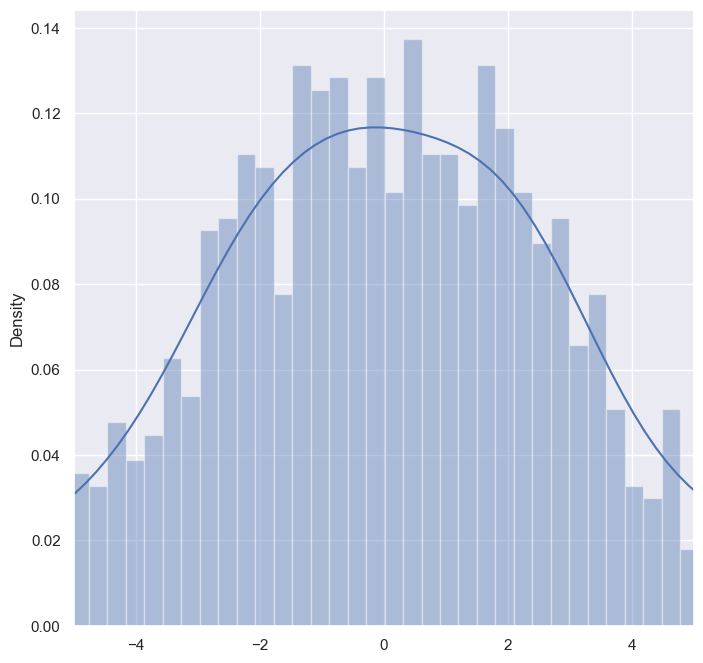

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-5,5])
sns.distplot(result.resid,bins=100);

We want this plot to look Gaussian, as it is our departing assumption (Gaussian error). For this reason this plot is a direct indicator of model validity.

Another plot we can use to validate our model is a QQ-plot.

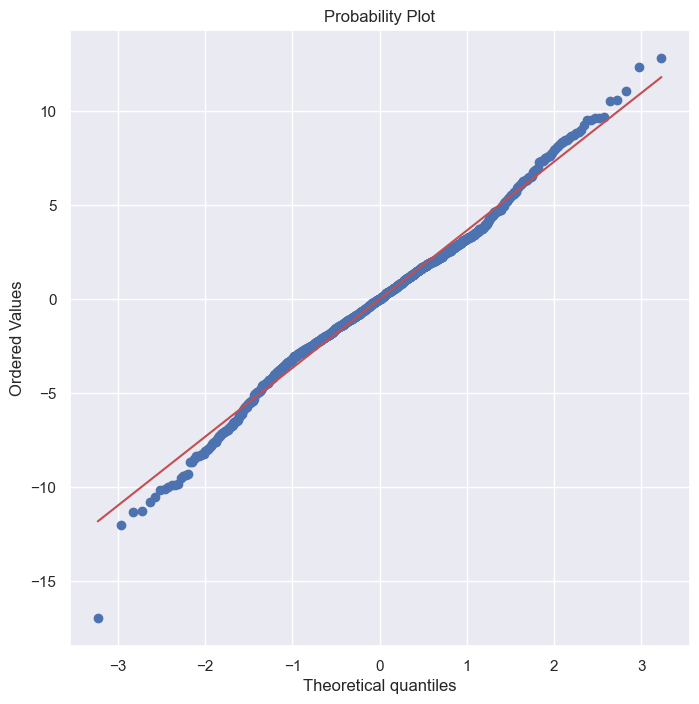

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
stats.probplot(result.resid, plot=plt);

## SECTION 3: Metrics

There are alternative metrics we can use to measure the performance of a regression model. 
We will review the most common ones over the training data predictions. 

**Mean Squared Error (MSE)** 

The best possible result would be a MSE of 0 sa it would mean a perfect prediction. 

$MSE(t,y) = \frac{1}{N} \sum_{i=1}^N (t - y(x;w))^2$

In [53]:
N = X_train.shape[0]

# using statsmodel
prediction = result.predict(sm.add_constant(X_train))
mean_square_error = np.sum((y_train - prediction)**2)/N

# You can also use sklearn implementation
mean_square_error_sk = mean_squared_error(y_train, prediction)

mean_square_error, mean_square_error_sk

(13.4809180674423, 13.4809180674423)

This number depends on the magnitude of the targets, so we cannot know if it is good or bad as it is. 
It is a very good practise to normalise it by dividing by the unbiased sample variance of the target. This way we obtain the 

**Normalized Mean Squared Error**

Again, the best possible result would be 0, for the same reason.

$norm\_MSE(t,y) = \frac {MSE(t,y)}{\sigma^2(t)} $


In [54]:
norm_mse = np.sum((y_train - prediction)**2)/((N)*np.var(y_train))

# You can also use sklearn r2 implementation to calculate this value
norm_mse_sk = 1-r2_score(y_train,prediction)

norm_mse, norm_mse_sk

(0.17104150205288346, 0.1710415020528835)

 If we divide the mean square error by the variance of the targets t,
 we get the proportion of the variability of the target that is NOT explained by the model

 A model with 'norm.mse' equal to 1 is as good as the best constant model
 (namely, the model that always outputs the average of the target)

 models with 'norm.mse' above 0.5 are so so, beyond 0.7 they begin to be quite bad

 models with 'norm.mse' below 0.2 are quite good

**Multiple R-squared (R^2)**

The Multiple R-squared (R^2) (usually used by statisticians) is obtained by subtracting this quantity from one; that is, the proportion of the target variability that is explained by the model; in this case it reaches ~80%

This metric is usually shown between 0 and 1 or in percentage.

In [55]:
R_squared = (1 - norm_mse)

# You can also use sklearn implementation
R_squared_sk = r2_score(y_train,prediction) 

R_squared, R_squared_sk

(0.8289584979471165, 0.8289584979471165)

In [56]:
X_train.shape

(1123, 19)

We have seen here that the model has good results with the training data, but does not mean our model is a good predictor. 
To have a numerical asessment of its predictive ability we have several options: 
* Get new data (not possible here!)
* Use LOOCV. 
* Predict on an specific validation partition and calculate the relevant measures.
* Use Cross-Validation. 

We haven't saved a specific partition for obtaining validation metrics and we have too many samples (1123 in train) for doing LOOCV fast. For this reason we will do Cross-Validation. 

## SECTION 4: Cross Validation

We need to know how good is our model. We cannot use the train dataset for this because it might give artificially good results. We cannot use the test partition because we will need to compare theses results with the ones obtained on other models. We want to use the test set only at the end, so it can simulate runing the model on new data. This way we can obtain a generalization error as close as possible to the error we would get using the model on completely new data. 

As we cannot use neither the train or the test sets for evaluating the model we will use **Cross-Validation** for computing our metrics, we will use our cross-validation metrics to compare models and take any design decissions.



![](cross_validation.PNG) 

In [57]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

kf = KFold(n_splits=5)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,6) if j != i]))
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]
    
    lr = LinearRegression()
    lr.fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    print('\tMSE: {} NMSE: {} R2: {}'.format(fold_mse,fold_nmse, fold_r2) )

    cross_val_metrics.loc['Fold {}'.format(i), :] = [fold_mse,fold_nmse, fold_r2]
    i+=1
    
    
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5]
	MSE: 15.12577421795703 NMSE: 0.1563931686664547 R2: 0.8436068313335453
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5]
	MSE: 12.915315412686658 NMSE: 0.18585284699458748 R2: 0.8141471530054125
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5]
	MSE: 15.12089978445527 NMSE: 0.20543699302539853 R2: 0.7945630069746015
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5]
	MSE: 13.264579224652143 NMSE: 0.16953503964625682 R2: 0.8304649603537432
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4]
	MSE: 13.932224012440347 NMSE: 0.18903847219343972 R2: 0.8109615278065603


,MSE,norm_MSE,R2
Fold 1,15.126,0.156,0.844
Fold 2,12.915,0.186,0.814
Fold 3,15.121,0.205,0.795
Fold 4,13.265,0.17,0.83
Fold 5,13.932,0.189,0.811
Mean,14.072,0.181,0.819


We will use the mean of the folds as our metrics. We can also do this using sklearn cros_val_score  method.

In [58]:
lr = LinearRegression()
lr.fit(X_train,y_train)
folds_r2 = cross_val_score(lr, X_train,y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2) 
folds_r2, lr_r2

(array([0.84360683, 0.81414715, 0.79456301, 0.83046496, 0.81096153]),
 0.8187486958947682)

## SECTION 5: Regularized Linear Regression: Ridge and Lasso

Now that we have a way to evaluate our model performance, let's see if it improves by adding regularization. 

### Ridge Regression

This time we are going to minimize the following function:

$\min_w (|| y - Xw ||^2 + \lambda * ||w||^2_2)$

The last term penalizes weights being to large (in magnitude). 
The lambda hyperparameter will control how much we are penalizing them. 

Lambda is not computed over the training process like the weights -- it is a *hyper-parameter*. 
So now the question is: How can we find the best lambda for our dataset? 

We have said on the previous section that we can use cross-validation metrics for comparing different models predictive performance. We can do the same to compare the same model with different hyperparameters.

In [59]:
ridge_cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])
lambdas = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
# We calculate the cross-validation metrics for each lambda 
for lambda_val in lambdas:
    kf = KFold(n_splits=5)
    i=1
    cv_mse = []
    cv_nmse = []
    cv_r2 = []
    # We compute the metrics for each fold and then perform the mean.
    for train_index, test_index in kf.split(X_train):
        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index,:]
        y_test_fold = y_train.values[test_index]

        lr = Ridge(alpha=lambda_val)
        lr.fit(x_train_fold,y_train_fold)
        y_pred_fold = lr.predict(x_test_fold)
        fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)
        cv_mse.append(fold_mse)
        cv_nmse.append(fold_nmse)
        cv_r2.append(fold_r2)
    ridge_cross_val_metrics.loc['Lambda={}'.format(lambda_val),:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]
    
ridge_cross_val_metrics.sort_values(by='mean R2',ascending=False)

,mean MSE,mean norm_MSE,mean R2
Lambda=1e-10,14.072,0.181,0.819
Lambda=1e-05,14.072,0.181,0.819
Lambda=0.0001,14.072,0.181,0.819
Lambda=0.001,14.072,0.181,0.819
Lambda=0.01,14.072,0.181,0.819
Lambda=0.1,14.072,0.181,0.819
Lambda=0.5,14.074,0.181,0.819
Lambda=1,14.082,0.181,0.819
Lambda=5,14.214,0.183,0.817
Lambda=10,14.396,0.186,0.814


Another way to do this is ussing sklearn implementation.

In [60]:
ridge_cv =RidgeCV(alphas=lambdas,cv=5)
ridge_cv.fit(X_train,y_train)

print('Best lambda:', ridge_cv.alpha_, 'R2 score:', ridge_cv.best_score_)

Best lambda: 1e-10 R2 score: 0.8187486958953055


Ridge Regression does not seem to improve the results of linear regression. Let's check if Lasso turns out  to work better. 

### Lasso Regression

This time we penalize weights using their L1 norm. 


$\min_w (|| y - Xw ||^2 + \lambda * |w|)$

We will use scikit-learn's CV method to compute the best lambda directly. 

In [61]:
lasso_cv =LassoCV(alphas=lambdas,cv=5)
lasso_cv.fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 1e-10 R2 score: 0.8187949912446797


In [62]:
r2_results = pd.DataFrame({'lr':lr_r2, 'ridge_cv':ridge_cv.best_score_, 'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lr.predict(X_train)),
                                r2_score(y_train,ridge_cv.predict(X_train)),
                                r2_score(y_train,lasso_cv.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.819,8.187e-01,8.188e-01
Train R2,0.815,8.290e-01,8.290e-01
lambda,0.000,1.000e-10,1.000e-10


## SECTION 6: Understanding our models is important

We can't see a great improvement with Lasso either. 

So, why is regularization not working when it is supposed to give better models? 

Let's check the weights of our three models. 

In [63]:
weights = pd.DataFrame({'lr':lr.coef_, 'ridge_cv':ridge_cv.coef_, 'lasso_cv':lasso_cv.coef_},index=X_train.columns)
weights.T

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
lr,-0.087,-0.017,0.112,-0.018,1.194e-04,-0.011,-2.197e-05,0.036,-0.081,0.005,0.053,0.021,-0.447,6.457e-05,-3.883e-09,-0.092,-0.009,1.140,1.215
ridge_cv,-0.139,-0.016,0.098,-0.116,3.110e-04,-0.004,-1.998e-05,0.026,-0.072,0.001,0.059,0.014,-0.446,2.718e-05,-3.213e-09,-0.013,-0.083,10.673,0.952
lasso_cv,-0.139,-0.016,0.098,-0.116,3.109e-04,-0.004,-1.989e-05,0.026,-0.071,0.001,0.059,0.014,-0.446,2.719e-05,-3.189e-09,-0.013,-0.083,10.676,0.952


Visually:

<Axes: >

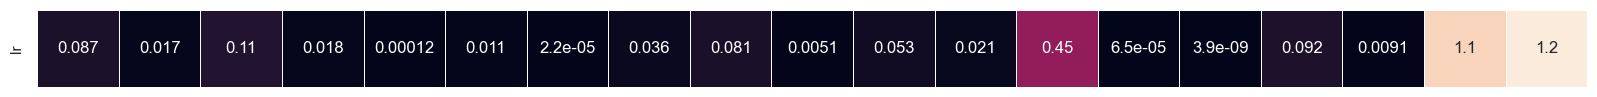

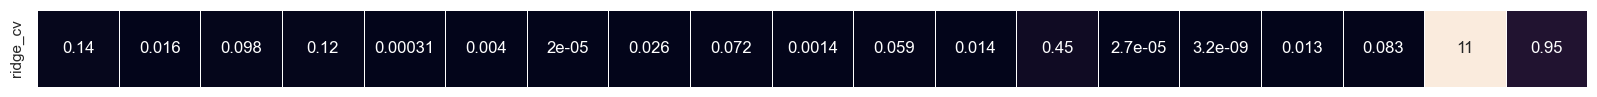

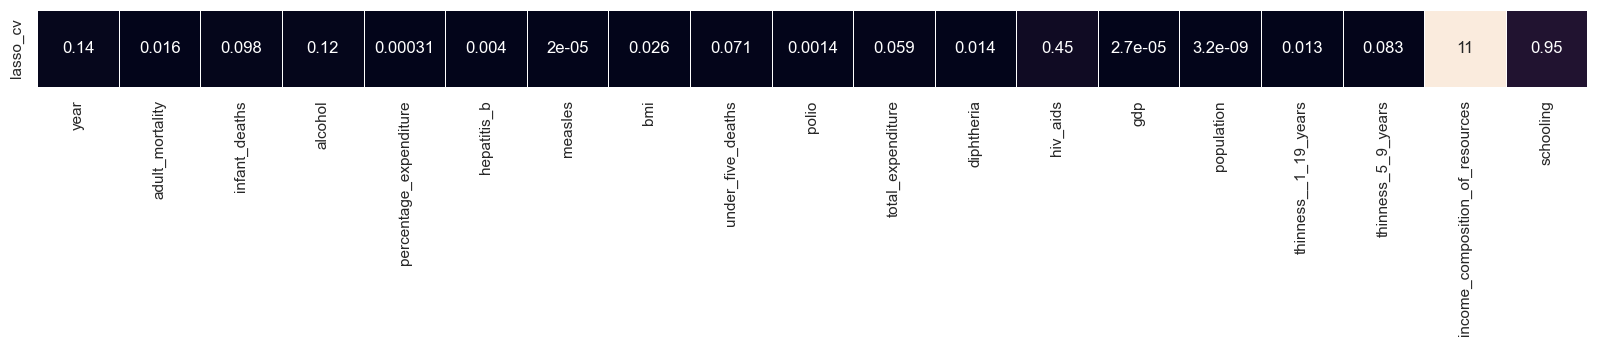

In [64]:
fig,  ax = plt.subplots( figsize = (20,1))
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False)

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False)

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True)

We can see some strange patterns in our weights, in the three models we can see a wide range of values. Both lasso and ridge have almost the same weights. 

If we compare the weights with the mean values of our variables we can see that the linear regression is trying to balance the variable ranges. That's probably why our regularized models are not working so well. 

<Axes: >

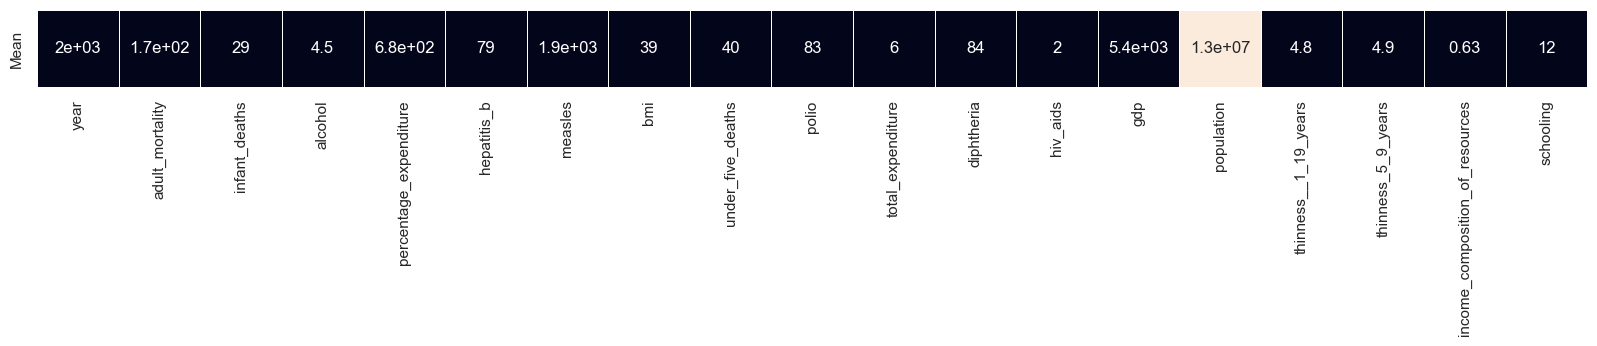

In [65]:
plt.figure(figsize = (20,1))
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True)

We are going to fix this by scaling our data. This way, all variables will have the same range and we will take better advantage of our models.

**Note that the pre-processing is slightly different for train data than for test data. Eseentially, this is to avoid any type of "leakage"**

In [66]:
def scaling_preprocessing(X, y, scaler=None):
    print('Original shape:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    
    # We scale the numerical columns
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    
    # We kill categorical columns
    X=X.drop(columns=categorical_columns)
    print('Droped: {}'.format(categorical_columns))
    # We remove missing values
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y, scaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train, scaler = scaling_preprocessing(X_train,y_train)
X_test, y_test, _ = scaling_preprocessing(X_test,y_test,scaler)

Original shape:(1968, 21)
Droped: ['country' 'status']
New shape:(1123, 19)
Original shape:(970, 21)
Droped: ['country' 'status']
New shape:(526, 19)


Now our variables have more reasonable ranges. Lets see how this affects our model weights and performance.

<Axes: >

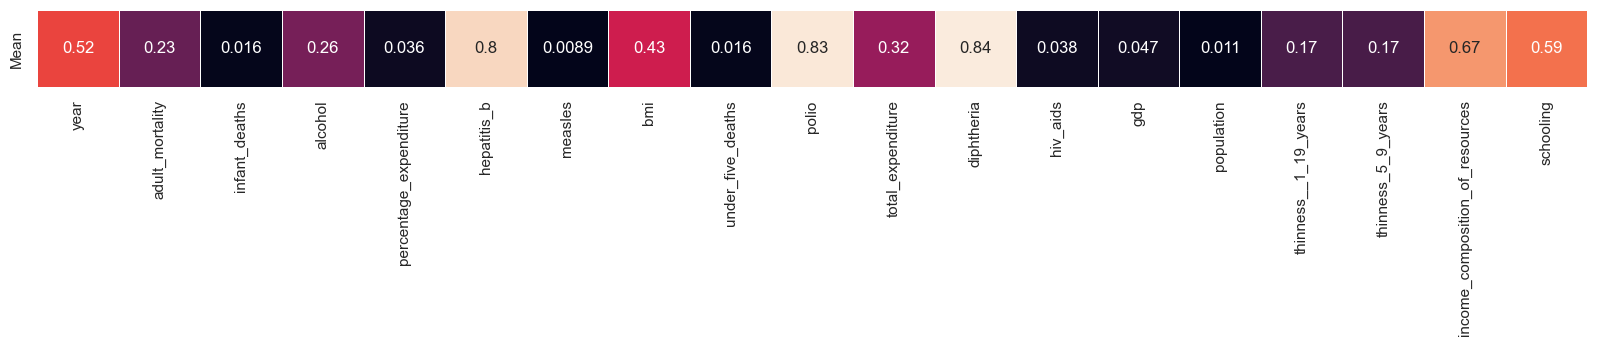

In [67]:
plt.figure(figsize = (20,1))
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True)

In [68]:
lr_scaled = LinearRegression()
lr_scaled.fit(X_train,y_train)
r2_lr_scaled = np.mean(cross_val_score(lr_scaled, X_train,y_train, cv=5, scoring='r2'))

ridge_cv_scaled =RidgeCV(alphas=lambdas,cv=5)
ridge_cv_scaled.fit(X_train,y_train)
r2_ridge_scaled = np.mean(cross_val_score(ridge_cv_scaled, X_train,y_train, cv=5, scoring='r2'))


lasso_cv_scaled =LassoCV(alphas=lambdas,cv=5)
lasso_cv_scaled.fit(X_train,y_train)
r2_lasso_scaled = np.mean(cross_val_score(ridge_cv_scaled, X_train,y_train, cv=5, scoring='r2'))

weights = pd.DataFrame({'lr scaled':lr_scaled.coef_, 'ridge_cv scaled':ridge_cv_scaled.coef_, 'lasso_cv scaled':lasso_cv_scaled.coef_},index=X_train.columns)
weights.T

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
lr scaled,-2.083,-11.893,177.291,-1.998,5.939,-0.388,-4.240,2.268,-179.223,0.132,0.984,1.394,-22.502,3.147,-3.790,-0.351,-2.367,10.118,19.513
ridge_cv scaled,-2.112,-11.934,161.826,-2.082,5.822,-0.384,-3.834,2.272,-163.923,0.143,0.979,1.422,-22.522,3.260,-3.301,-0.342,-2.337,10.179,19.551
lasso_cv scaled,-2.101,-11.925,165.624,-2.051,5.850,-0.380,-3.848,2.274,-167.776,0.138,0.977,1.411,-22.513,3.221,-3.329,-0.343,-2.338,10.163,19.529


In [69]:
r2_results = pd.DataFrame({'lr':r2_lr_scaled, 'ridge_cv':r2_ridge_scaled, 'lasso_cv':r2_lasso_scaled,},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lr_scaled.predict(X_train)),
                                r2_score(y_train,ridge_cv_scaled.predict(X_train)),
                                r2_score(y_train,lasso_cv_scaled.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv_scaled.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv_scaled.alpha_
r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.819,0.819,8.187e-01
Train R2,0.829,0.829,8.289e-01
lambda,0.000,0.001,1.000e-04


The results haven't improved much. Perhaps including categorical variables helps. 

We have two categorical variables. Country and status. 

In [70]:
categorical_columns = X.dtypes[X.dtypes == 'O'].index.values
categorical_columns

array([], dtype=object)

In [71]:
def categorical_preprocessing(X, y, scaler=None):
    print('Original shape:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    
    # Scale numerical variables
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    
    # Apply one hot encoding to categorical variables
    for column in categorical_columns:
        X_one_hot = pd.get_dummies(X[column], prefix=column)
        X = X.merge(X_one_hot,left_index=True,right_index=True)
        X = X.drop(columns=[column])
    
    # Drop missings
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y, scaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

Original shape:(1968, 21)
New shape:(1123, 214)
Original shape:(970, 21)
New shape:(526, 214)


If we use this new pre-processing we obtain super good results on the training set but super bad results on cross-validation. 

This means our model wont be able to generalize if we try to use it on new data. 

How can it be that having more information our model is performing worse?

In [72]:
lr_one_hot = LinearRegression()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))

Train R2 score: 0.966296769674408
Cross-Validation R2 score: -8.020494966173409e+21


We have two problems with our model: 
1. It is **overfitting** the training data. So, when it receives new data that has not been used on training it is not able to predict. 
2. This might be caused by the **curse of dimensionallity**. We have 214 variables for 1123 samples, which is not a great ratio. 

We can also see on the weights of our model that there is something wrong, as there are differences between the weight ranges. 

<Axes: >

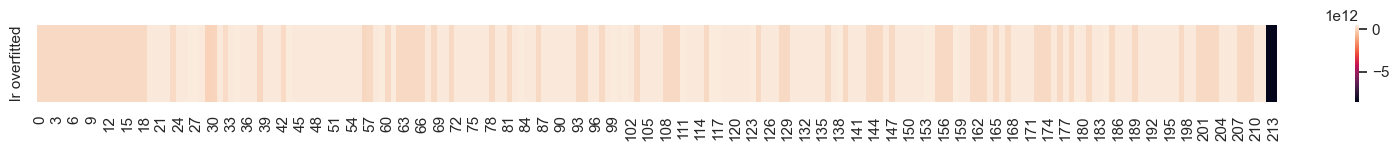

In [73]:
plt.figure(figsize = (20,1))
sns.heatmap(pd.DataFrame({'lr overfitted':lr_one_hot.coef_}).T)

Finally, if we check what our data looks like, we will see that we have a very sparse matrix. So, on top of all our problems we are trying to use SVD on a sparse matrix, which is not ideal. 

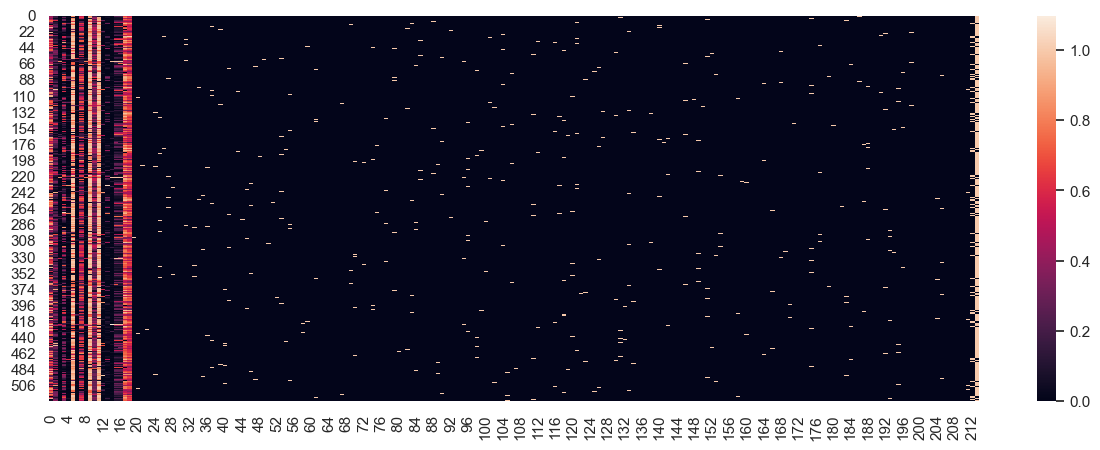

In [74]:
plt.figure(figsize=(15,5));
sns.heatmap(X_test.to_numpy(dtype=float));

For fixing overfitting we can either remove this variable or apply regularization. Let's see how our regularized models behave.

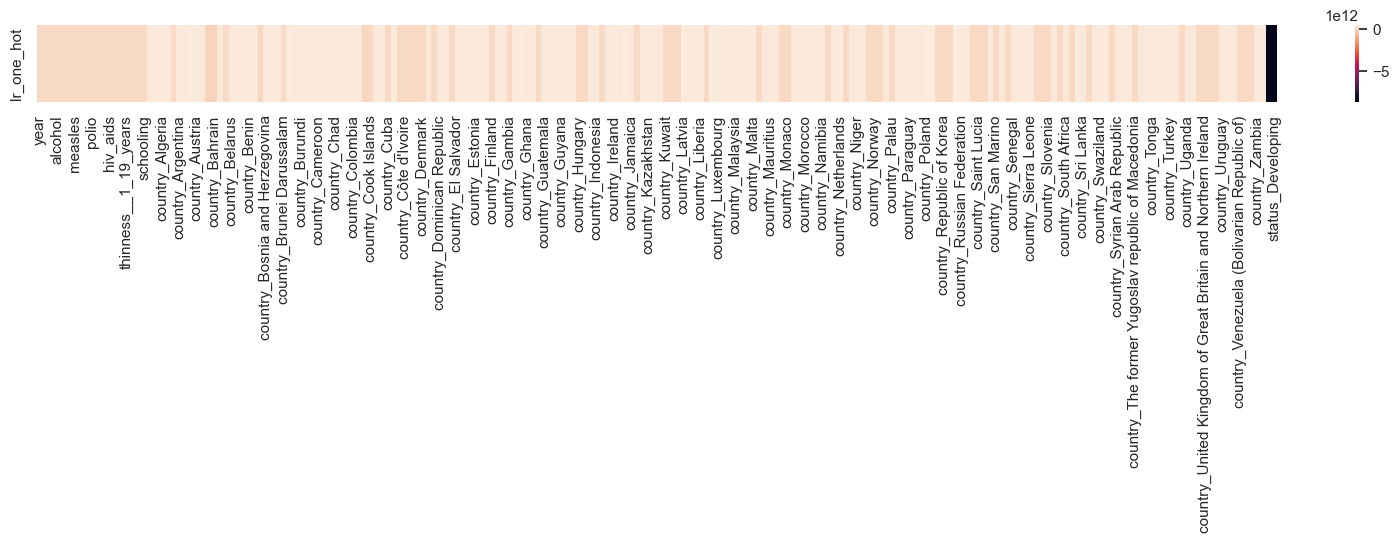

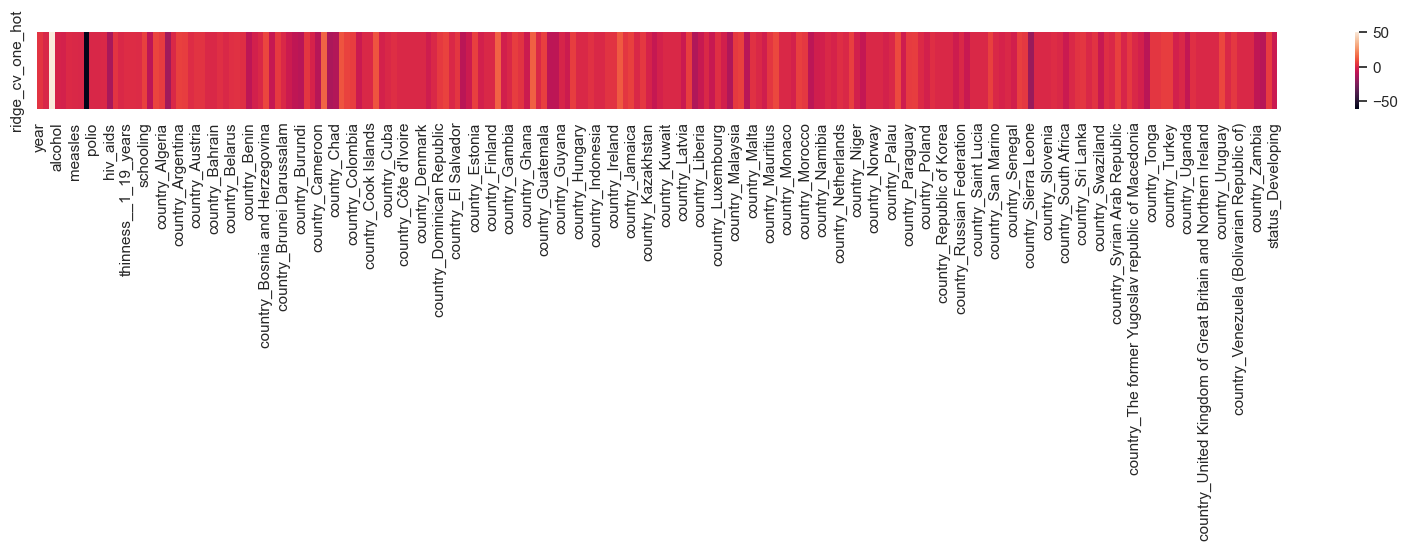

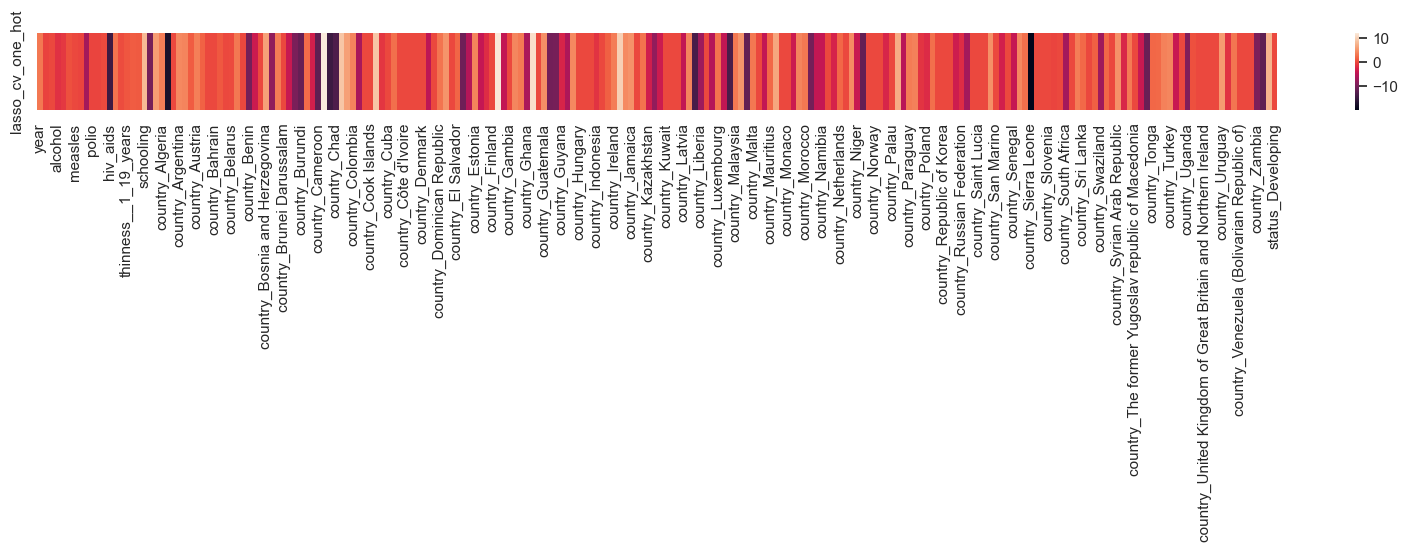

In [75]:
ridge_cv_one_hot = RidgeCV(alphas=lambdas, cv=5)
ridge_cv_one_hot.fit(X_train, y_train)

r2_ridge_one_hot_train = ridge_cv_one_hot.score(X_train,y_train)
r2_ridge_one_hot_cv = np.mean(cross_val_score(ridge_cv_one_hot, X_train, y_train, cv=5, scoring='r2'))

lasso_cv_one_hot = LassoCV(alphas=lambdas, cv=5)
lasso_cv_one_hot.fit(X_train, y_train)

r2_lasso_one_hot_train = ridge_cv_one_hot.score(X_train,y_train)
r2_lasso_one_hot_cv = np.mean(cross_val_score(lasso_cv_one_hot, X_train, y_train, cv=5, scoring='r2'))

weights = pd.DataFrame(
    {
        'lr_one_hot': lr_one_hot.coef_,
        'ridge_cv_one_hot': ridge_cv_one_hot.coef_,
        'lasso_cv_one_hot': lasso_cv_one_hot.coef_
    },
    index=X_train.columns)

for column in weights.columns:
    fig= plt.figure(figsize=(20,1))
    ax=sns.heatmap(weights[[column]].T)

We obtain smaller weights on our regularized models. Will this affect our models performance?

In [76]:
r2_results.loc[:, 'lr_one_hot'] =[r2_lr_one_hot_cv, r2_lr_one_hot_train, 0]
r2_results.loc[:, 'ridge_cv_one_hot'] =[r2_ridge_one_hot_cv, r2_ridge_one_hot_train, ridge_cv_one_hot.alpha_]
r2_results.loc[:, 'lasso_cv_one_hot'] =[r2_lasso_one_hot_cv, r2_lasso_one_hot_train, lasso_cv_one_hot.alpha_]
r2_results

,lr,ridge_cv,lasso_cv,lr_one_hot,ridge_cv_one_hot,lasso_cv_one_hot
CV R2,0.819,0.819,8.187e-01,-8.020e+21,0.951,9.493e-01
Train R2,0.829,0.829,8.289e-01,9.663e-01,0.966,9.662e-01
lambda,0.000,0.001,1.000e-04,0.000e+00,0.001,1.000e-04


We can see in our cv metrics that regularization improves performance **a lot**. This way the model can take advantage of the extra data we are feeding it and effectively control overfitting. 

## SECTION 7: Model selection

Now we use the cv R2 to choose the best model and give the test R2 as our resulting R2 measure. According to our validation metrics, the best model is ridge_cv with a lambda of 0.001 used with the standarized dataset with categorical variables. 

Now that we have taken all the decisions concerning our model and data pre-processing. We use the test set to see how the model generalizes. This step is supposed to simulate seen how the model performs with *completely new* data, namely, data it has never seen before.

**Typically, before testing the "winning method" we would re-fit it on the whole training data; the RidgeCV method does this by default for us so we do not need to do this here.**

It is important to use the test set only to give the final performance, otherwise we risk giving an over optimistic result. 

In [77]:
y_tes_predicted = ridge_cv_one_hot.predict(X_test)
r2_ridge = ridge_cv_one_hot.score(X_test,y_test)

print('Mean sqared error with test data: {}'.format(mean_squared_error(y_test,y_tes_predicted)))
print('R2 score with test data: {}'.format(r2_ridge))

Mean sqared error with test data: 2.63732802823968
R2 score with test data: 0.9644304797923887
